# Goals

Develop explanatory GEP x ligand matrix for use in ridge regression models of ligand activity prediction. We want to:

* Remove ligands that have weak or no effects on sPCA component scores
* Aggregate highly co-linear signaling activities

# Import

In [1]:
import scanpy as sc
import pandas as pd
import decoupler as dc
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, '/data1/rudenska/EYW/git_projects/SIG13/functions')
import scanpy_custom as scc

%load_ext autoreload
%autoreload 2

In [2]:
# import sPCA components and LM results
spca_components = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/spca/zscore_degs_allLigands_0.1_alpha1.0_sPCA_loadings.csv")
lm_scored = pd.read_csv('/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/spca/lm_scored_zscore_degs_allLigands_0.1_alpha1.0_sPCA_clean.csv')
lm_fit = pd.read_csv('/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/spca/lm_fit_zscore_degs_allLigands_0.1_alpha1.0_sPCA_clean.csv')

# import hdbscan clusters based on interaction coefficient
hdbscan_clusters = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/clustering/hdbscan_interaction_coeff_clusters.csv")

# import inter-replicate correlation based on interaction LFCs and total LFCs
interRepCor = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/replicate_corr/replicate_correlation_interactionLfc_0.2filter.csv")
totalRepCor = pd.read_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/replicate_corr/replicate_correlation_singleLfc_0.2filter.csv")

In [3]:
# import SIG13 anndata
rna = sc.read_h5ad("/data1/rudenska/EYW/SIG13/scanpy_outs/SIG13_doublets_DSB7.h5ad")

# SIG13 Scoring

First, we will calculate sPCA scores for the components using a weighted mean of scaled log1p_norm component genes. Then, I will calculate the difference between stimulation conditions and linker_linker to create the explanatory matrix.

In [4]:
# filter for good components (those not strongly associated with replicates)
good_comps = lm_scored['component'].unique().tolist()
spca_components = spca_components[spca_components['spca_component'].isin(good_comps)]
# format for decoupler
net = spca_components.rename(columns={'gene':'target',
                                      'spca_component':'source',
                                      'loading':'weight'})
# define genes used in scoring
comp_genes = net['target'].unique().tolist()

In [5]:
# subset and scale 
rna_sub = rna[:,comp_genes].copy()
rna_sub.X = rna_sub.layers['log1p_norm']
sc.pp.scale(rna_sub)

# calculate pseudobulk 
rna_pb = sc.get.aggregate(rna_sub, by=['ligand_call_DSB7'], func='mean')

/home/wange7/miniforge3/envs/scanpy_standard2/lib/python3.13/functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


In [6]:
# calculate waggr without any permutations (no pvalues needed)
dc.mt.waggr(rna_pb, net, tmin=5, verbose=True, layer='mean', times=0)

# Extract score_waggr and padj_waggr from rna_pb.obsm
score_df = pd.DataFrame(rna_pb.obsm['score_waggr'], 
                        index=rna_pb.obs_names, 
                        columns=rna_pb.obsm['score_waggr'].columns)

# Calculate differential scores by subtracting linker_linker scores from all conditions
linker_scores = score_df.loc['linker_linker']
score_df = score_df.subtract(linker_scores, axis=1)

2026-02-04 11:10:12 | [INFO] waggr - Running waggr
2026-02-04 11:10:12 | [INFO] Extracted omics mat with 660 rows (observations) and 5246 columns (features)
2026-02-04 11:10:12 | [INFO] Network adjacency matrix has 5246 unique features and 68 unique sources
2026-02-04 11:10:12 | [INFO] waggr - using function _wmean
2026-02-04 11:10:12 | [INFO] waggr - using _wmean for the first time, will need to be compiled
2026-02-04 11:10:12 | [INFO] waggr - calculating scores for 68 sources across 660 observations
2026-02-04 11:10:13 | [INFO] waggr - adjusting p-values by FDR
2026-02-04 11:10:13 | [INFO] waggr - done


# Activity Selection

Next, we filter for ligands that have a significant effect on sPCA components and are well correlated between replicates. We will also aggregate similar activities into consensus activities.

## Select Single Activities

In [7]:
# select single ligands based on pearson correlation cutoff
consistent_ligands = totalRepCor.loc[((totalRepCor['pearson_corr'] > 0.25))]
consistent_ligands.loc[:,'condition'] = consistent_ligands['condition'].str.replace('linker_|_linker','', regex=True)
consistent_ligands = consistent_ligands['condition'].unique()

# pull out single terms from lm of spca component scores
spca_lm_singles = lm_fit[~lm_fit.term.str.contains(':')]
spca_lm_singles.loc[:,'term'] = spca_lm_singles['term'].str.replace('ligand1|ligand2','', regex=True)

# define active ligands
spca_active_ligands = spca_lm_singles.query('p_adj < 0.01 & term in @consistent_ligands')['term'].unique()

In [8]:
spca_active_ligands

array(['IFNG', 'IL2', 'IL21', 'IL27', 'IL4', 'IL6', 'IFNA', 'IFNB1',
       'IFNK', 'TNFSF18', 'IL7', 'TNF', 'TNFSF15', 'TGFB1', 'TNFSF4',
       'TSLP', 'TNFSF9', 'CCL21A', 'CCL19'], dtype=object)

## Aggregate Single Activities

To aggregate singe ligand activities, we will perform pearson correlation clustering of single ligands and examine the pairwise correlation heatmap to manually aggregate activities.

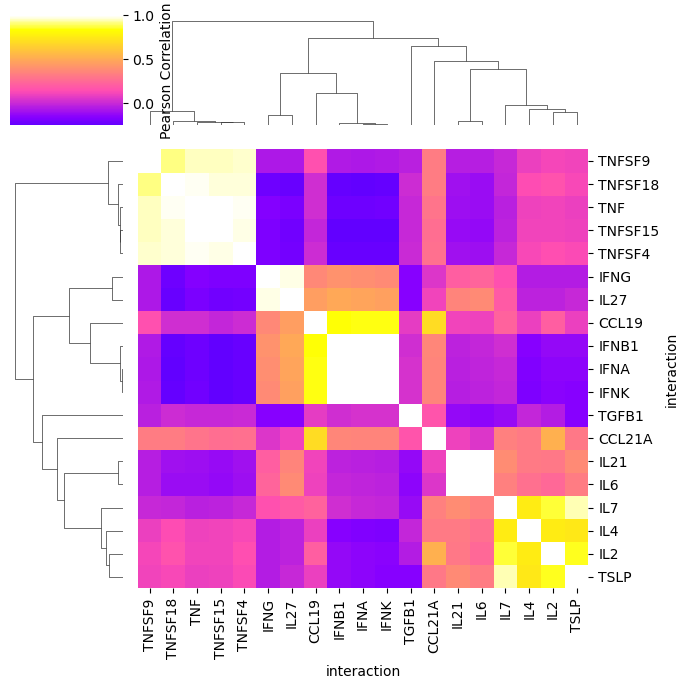

In [12]:
# Calculate pairwise Pearson correlations between single ligand conditions
score_df_linker = (score_df
                   .query("index.str.contains('linker')", engine='python'))
score_df_linker.index = score_df_linker.index.str.replace('linker_|_linker', '', regex=True)
score_df_linker_filtered = (score_df_linker
 .query("index.isin(@spca_active_ligands)", engine='python')
 .reset_index(names='interaction')
 .groupby('interaction')
 .mean())
corr_matrix = score_df_linker_filtered.T.corr(method='pearson')

# Create clustermap
sns.clustermap(corr_matrix, cmap='gnuplot2', center=0, 
               figsize=(7, 7), 
               cbar_kws={'label': 'Pearson Correlation'})
plt.tight_layout()
plt.show()

In [13]:
# Create a dictionary mapping each ligand to its manual group
# -1 = not assigned to a group
manual_group_dict = {
    'IL23':-1,
    'TNFSF9':100,
    'TNFSF18':100,
    'TNF':100,
    'TNFSF15':100,
    'TNFSF4':100,
    'IFNG':200,
    'IL27':200,
    'CCL19':-1,
    'IFNB1':300,
    'IFNA':300,
    'IFNK':300,
    'TGFB1':-1,
    'CCL21A':-1,
    'IL21':400,
    'IL6':400,
    'IL7':-1,
    'IL4':-1,
    'IL2':-1,
    'TSLP':-1
}

# Create the manual_group column by mapping the index
score_df_linker_filtered['manual_group'] = score_df_linker_filtered.index.map(manual_group_dict)

# Determine the "Name" for each cluster 
# (We pick the ligand name with the highest row mean to represent the cluster)
cluster_names = (score_df_linker_filtered
                 .query('manual_group != -1')
                 .assign(row_mean=lambda x: x.drop(columns=['manual_group']).mean(axis=1))
                 .groupby('manual_group')['row_mean']
                 .idxmax()) # Returns a Series mapping Cluster ID -> Ligand Name
cluster_names = cluster_names + ['_c']

# make df of activity names
single_names = score_df_linker_filtered.reset_index()
single_names = single_names[['interaction', 'manual_group']]
single_names = single_names.merge(cluster_names, left_on='manual_group', right_index=True, how='left')
single_names['row_mean'] = single_names['row_mean'].fillna(single_names['interaction'])

# Calculate the Mean of the groups and rename the index
score_df_linker_grouped = (score_df_linker_filtered
                            .query('manual_group != -1')
                                 .groupby('manual_group')
                                 .mean()
                                 # Map the numbered cluster index to the Representative Ligand Name
                                 .set_axis(cluster_names, axis='index') 
                                 )

score_df_linker_unclustered = (score_df_linker_filtered
                                     .query('manual_group == -1')
                                     .drop(columns=['manual_group']))

# Combine clustered representatives and unclustered interactions
score_df_linker_filtered = pd.concat([score_df_linker_grouped, score_df_linker_unclustered])

## Select Combinatorial Activities

In [14]:
# select consistent interactions based on pearson correlation
consistent_interactions = interRepCor.loc[((interRepCor['pearson_corr'] > 0.25)), 
                                     'interaction'].unique()

# filter for interactions with significant interaction effects in component scores and good correlation
spca_active_interactions = lm_scored.query('p_adj_interaction < 0.01 & interaction in @consistent_interactions')['interaction'].unique()

In [15]:
spca_active_interactions

array(['IL2_IL2', 'IL21_IL21', 'IL2_CCL21A', 'IL2_IFNA', 'IL2_IFNB1',
       'IL2_IFNK', 'IL2_IL21', 'IL2_IL27', 'IL2_IL4', 'IL2_IL6',
       'IL2_IL7', 'IL2_TNF', 'IL2_TNFSF15', 'IL2_TNFSF18', 'IL2_TNFSF4',
       'IL21_IL2', 'IL21_IL4', 'IL21_IL6', 'IL27_IL2', 'IL27_IL7',
       'IL4_CCL21A', 'IL4_IFNA', 'IL4_IFNB1', 'IL4_IFNK', 'IL4_IL2',
       'IL4_IL21', 'IL4_IL4', 'IL4_IL6', 'IL4_IL7', 'IL6_IL2', 'IL6_IL6',
       'IL6_IL7', 'IL7_CCL21A', 'IL7_IFNA', 'IL7_IFNB1', 'IL7_IL2',
       'IL7_IL27', 'IL7_IL4', 'IL7_IL6', 'IL7_IL7', 'TNF_IL2', 'TNF_TNF',
       'IFNG_IFNB1', 'IL21_IL27', 'IL21_TNFSF18', 'IL27_IL27', 'IL27_IL6',
       'IL4_TNFSF18', 'IL6_IFNB1', 'IL6_IL21', 'IL6_IL27', 'IL6_TNFSF18',
       'TGFB1_CCL21A', 'TGFB1_IL21', 'TGFB1_IL4', 'TGFB1_IL6', 'IFNG_IL7',
       'IL2_IFNG', 'IL21_IL7', 'IL21_TNFSF15', 'IL27_IL4', 'IL4_IFNG',
       'IL4_IL27', 'IL4_TNF', 'IL6_IL4', 'IL7_IFNG', 'IL7_IL21',
       'IL7_TNFSF15', 'TNF_IL21', 'TNF_IL4', 'TNF_TNFSF18', 'IL2_TNFSF9',
      

## Aggregate Combinatorial Activities

In [16]:
# isolate interaction conditions
score_df_interactions = (score_df
                         .query("index.str.contains('linker')==False", engine='python'))
# filter for selected combinations
score_df_interactions = score_df_interactions.loc[spca_active_interactions]
# join with hdbscan clusters
score_df_interactions = (score_df_interactions
                         .merge(hdbscan_clusters[['interaction','hdbscan_cluster_1']],
                                left_index=True, right_on='interaction')
                         .set_index('interaction'))

In [17]:
# remove clusters that represent double dose sitations
# 28: IL21/6 + IL21/6
# 29: IL2/4 + IL2/4
# 37: IFNG/IL27 + IFNG/IL27
double_dose_hdbscan_clusters_1 = [29, 28, 37]

Below, I am manually grouping conditions interactions because they do not cluster using the hdbscan parameters I am using although they are similar enough where I think they should be clustered based on manual inspection of gene-level interaction effect correlations. Many of these do cluster at hdbscan parameters that are more inclusive (e.g. form larger groups)

In [18]:
# merge with IL27_TNF group
manual_group = ['IFNG_TNFSF15','IFNG_TNFSF18']
# Assign manual_group to IL21/6 IFNG interactions, which clustered separately depending on IFNG position
manual_group2 = ['IL21_IFNG','IL6_IFNG','IFNG_IL21','IFNG_IL6']
manual_group3 = ['IL4_IFNG','IFNG_IL4']
manual_group5 = ['IL2_TSLP','IL4_TSLP']
manual_group6 = ['IFNG_IFNB1','IL27_IFNB1']
manual_group7 = ['IL2_TNFSF15','IL2_TNFSF4']
# merge with existing groups
score_df_interactions.loc[score_df_interactions.index.isin(manual_group), 'hdbscan_cluster_1'] = 13
score_df_interactions.loc[score_df_interactions.index.isin(manual_group2), 'hdbscan_cluster_1'] = 26
score_df_interactions.loc[score_df_interactions.index.isin(manual_group7), 'hdbscan_cluster_1'] = 19
# form new groups
score_df_interactions.loc[score_df_interactions.index.isin(manual_group3), 'hdbscan_cluster_1'] = 314
score_df_interactions.loc[score_df_interactions.index.isin(manual_group5), 'hdbscan_cluster_1'] = 2801
score_df_interactions.loc[score_df_interactions.index.isin(manual_group6), 'hdbscan_cluster_1'] = 3012

In [19]:
# Define interactions that need to be aggregated
df_filtered = (score_df_interactions
               .query('hdbscan_cluster_1 != -1')
               .query('hdbscan_cluster_1 not in @double_dose_hdbscan_clusters_1'))

# Determine the "Name" for each cluster 
# (We pick the ligand name with the highest row mean to represent the cluster)
cluster_names = (df_filtered
                 .assign(row_mean=lambda x: x.drop(columns=['hdbscan_cluster_1']).mean(axis=1))
                 .groupby('hdbscan_cluster_1')['row_mean']
                 .idxmax()) # Returns a Series mapping Cluster ID -> Ligand Name
cluster_names = cluster_names + '_c'

# Calculate the Mean of the groups and rename the index
score_df_interactions_grouped = (df_filtered
                                 .groupby('hdbscan_cluster_1')
                                 .mean()
                                 # Map the numbered cluster index to the Representative Ligand Name
                                 .set_axis(cluster_names, axis='index') 
                                 )

# Remove unclustered conditions that probably just didn't cluster appropriately
# I'm being conservative here and removing these just in case they introduce excessive colinearity into the model
manual_removed_interactions = ['IFNG_TNFSF4','IFNG_TNF','IL27_TNFSF4','IL2_TNFSF9','IL27_IL7','IL27_TNFSF15',
                               'IL7_IL21','IL7_IL6','TNF_TNFSF9','IFNG_IL7']
score_df_interactions_unclustered = (score_df_interactions
                                     .query('hdbscan_cluster_1 == -1')
                                     .drop(columns=['hdbscan_cluster_1'])
                                     # manually remove those unclustered interactions
                                     .query('interaction.isin(@manual_removed_interactions) == False'))

# Combine clustered representatives and unclustered interactions
score_df_interactions_filtered = pd.concat([score_df_interactions_grouped, score_df_interactions_unclustered])

# Construct Final Explanatory Matrix

In [20]:
# export ligand conditions and associated consensus activity names
# get cluster identities
clustered_interaction_names = df_filtered[['hdbscan_cluster_1']].reset_index()
clustered_interaction_names = clustered_interaction_names.merge(cluster_names, left_on='hdbscan_cluster_1', right_index=True, how='left')
clustered_interaction_names['activity_type'] = "combinatorial"
single_interaction_names = pd.DataFrame({'interaction': score_df_interactions_unclustered.index,
                                         'hdbscan_cluster_1': -1})
single_interaction_names['annotation'] = single_interaction_names['interaction']
single_interaction_names['activity_type'] = "combinatorial"
single_names['activity_type'] = "single"

# rename  columns
clustered_interaction_names.columns = ['activity', 'group','annotation','activity_type']
single_interaction_names.columns = ['activity', 'group','annotation','activity_type']
single_names.columns = ['activity', 'group','annotation','activity_type']

# merge all by row
full_clusters = pd.concat([clustered_interaction_names, single_interaction_names, single_names])

In [21]:
# merge single and combinatorial activities
score_merge = pd.concat([score_df_interactions_filtered, score_df_linker_filtered], axis=0)

# remove components that are associated with replicate effects
score_filtered = score_merge[good_comps].copy()
score_filtered.index.name = 'interaction'

# shape of final explanatory matrix
score_filtered.shape

(52, 68)

In [22]:
# Export
score_filtered_long = score_filtered.reset_index().melt(id_vars='interaction', 
                                                      var_name='component', 
                                                      value_name='diff_score')
# score_filtered.to_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/cytosig/SIG13_waggr_scores_explanatory_mat.csv")
# score_filtered_long.to_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/cytosig/SIG13_waggr_scores_explanatory_long.csv", index=False)
# full_clusters.to_csv("/data1/rudenska/EYW/git_projects/SIG13/analysis_outs/cytosig/SIG13_waggr_activity_clusters.csv", index=False)